In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

### IMPORTING LIBRARIES

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback(16KHZ)
sampling_rate = 16000

### DOWNLOADING MAESTRO DATASET

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 1s 0us/step


#### THE MAESTRO DATASET CONTAINS AROUND 1300 MIDI FILES

---



In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [ ]:
sample_file = filenames[10]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

data/maestro-v2.0.0/2008/MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--6.midi


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=sampling_rate)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*sampling_rate]
  return display.Audio(waveform_short, rate=sampling_rate)


In [ ]:
display_audio(pm)

#### PERFORMING ANALYSIS ON THE MIDI FILE

In [ ]:
pm.instruments

[Instrument(program=0, is_drum=False, name="")]

In [ ]:
print(f"Number of instruments: {len(pm.instruments)}")
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [ ]:
print(len(instrument.notes))

1862


We will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The `pitch` is the perceptual quality of the sound as a MIDI note number. The `step` is the time elapsed from the previous note or start of the track. The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    note_name = pretty_midi.note_number_to_name(note.pitch)
    notes['pitch'].append(note.pitch)
    notes['pitch_name'].append(note_name)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['velocity'].append(note.velocity)
    notes['duration'].append(end - start)
    
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
notes_df = midi_to_notes(sample_file)
notes_df.head()

,pitch,pitch_name,start,end,step,velocity,duration
0,67,G4,1.002604,1.062500,0.000000,65,0.059896
1,64,E4,1.156250,1.201823,0.153646,65,0.045573
2,48,C3,1.158854,1.203125,0.002604,56,0.044271
3,65,F4,1.282552,1.334635,0.123698,60,0.052083
4,67,G4,1.414062,1.455729,0.131510,65,0.041667


#### Plotting the Piano roll

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="g", marker=".",linewidth=7.0)
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

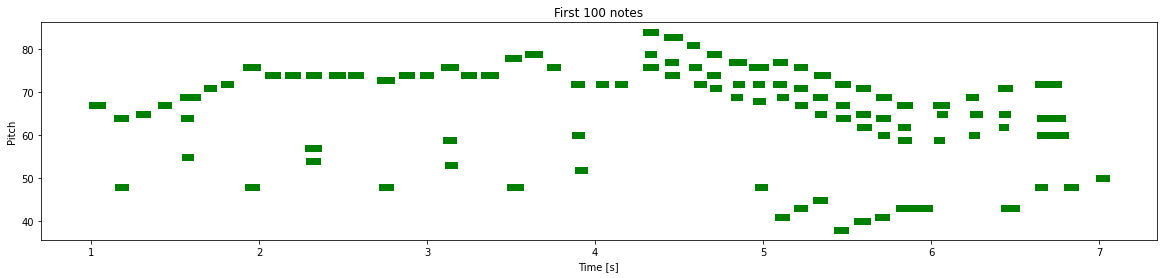

In [ ]:
plot_piano_roll(notes_df,count=100)

Check the distribution of each note variable.

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

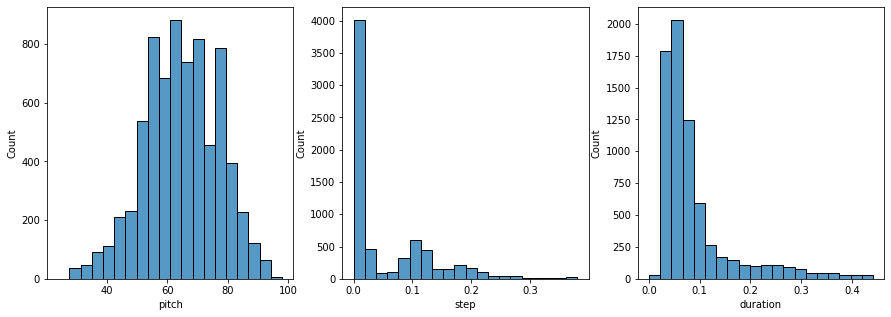

In [ ]:
plot_distributions(notes_df)

#### Creating a notes to midi function

In [ ]:
def notes_to_midi(notes: pd.DataFrame,out_file: str, instrument_name: str,velocity: int = 100) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(notes_df, out_file=example_file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

### Creating the training dataset

In [ ]:
num_files = 8
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 65131


Creating a Tensor Dataset(tf.data.Dataset) from parsed notes

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Model will be trained on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and next note as the label. In this way, the model will be trained to predict the next note in a sequence. 

Using the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size seq_length to create the features and labels in this format.

In [ ]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int,vocab_size = 128,) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Setting the sequence length as 25 but can be set to 25,50 and 100 depending upon which sequence_length is best

The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi.`

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

Create and Train the RNN Model

The model will have three outputs, one for each note variable. For `pitch` and `duration`, we are using a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3) # DEFINING THE INPUT SHAPE WHICH WILL GO INTO THE MODEL
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
1017/1017 [==============================] - 57s 45ms/step - loss: 0.4627 - duration_loss: 0.1583 - pitch_loss: 4.0781 - step_loss: 0.1005
Epoch 2/50
1017/1017 [==============================] - 44s 43ms/step - loss: 0.4500 - duration_loss: 0.1556 - pitch_loss: 3.9225 - step_loss: 0.0983
Epoch 3/50
1017/1017 [==============================] - 45s 44ms/step - loss: 0.4422 - duration_loss: 0.1528 - pitch_loss: 3.8726 - step_loss: 0.0958
Epoch 4/50
1017/1017 [==============================] - 44s 43ms/step - loss: 0.4371 - duration_loss: 0.1504 - pitch_loss: 3.8575 - step_loss: 0.0939
Epoch 5/50
1017/1017 [==============================] - 44s 43ms/step - loss: 0.4326 - duration_loss: 0.1475 - pitch_loss: 3.8456 - step_loss: 0.0928
Epoch 6/50
1017/1017 [==============================] - 43s 43ms/step - loss: 0.4271 - duration_loss: 0.1440 - pitch_loss: 3.8376 - step_loss: 0.0912
Epoch 7/50
1017/1017 [==============================] - 43s 43ms/step - loss: 0.4235 - duration_loss

**To evaluate the model, We shall be having a look at:**

 - The performance of the model via Learning Curves
 - The melody created

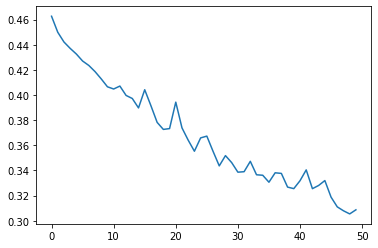

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

#### We can see the loss going down with every epoch

In [ ]:
model.save('music_model2.h5')

### Predicting the next note

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([notes_df[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head()

,pitch,step,duration,start,end
0,30,0.129821,0.057048,0.129821,0.186869
1,92,0.108421,0.147241,0.238242,0.385483
2,95,0.121169,0.255614,0.359412,0.615026
3,92,0.124635,0.277245,0.484047,0.761291
4,92,0.136964,0.307010,0.621011,0.928021


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

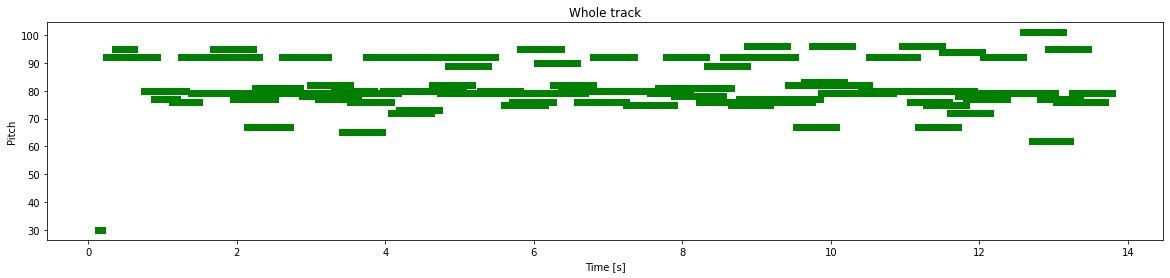

In [ ]:
plot_piano_roll(generated_notes)

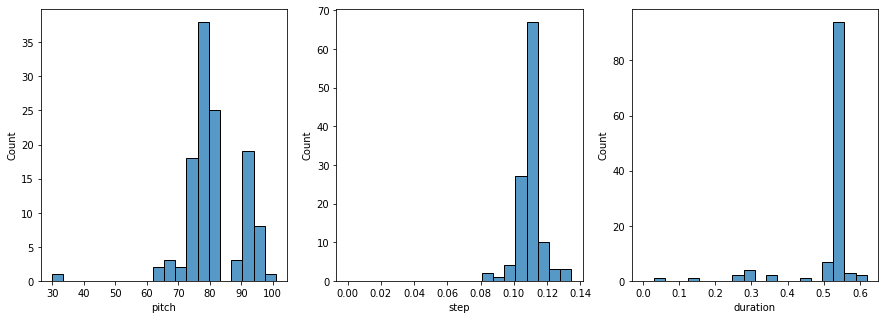

In [ ]:
plot_distributions(generated_notes)